# 👁️ The Vision Transformer (ViT)

In the previous notebook, we looked at CNNs (ResNet, EfficientNet). For a decade, Convolutions were the undisputed kings of Computer Vision. They are built on the idea that **local features** (edges, textures) are the most important building blocks of an image.

But in 2020, a paper titled **"An Image is Worth 16x16 Words"** changed everything. It asked: *Can we apply the standard Transformer architecture (from NLP) directly to images, with as few modifications as possible?*

The answer was **Yes**.

This notebook explores the **Vision Transformer (ViT)**. We will learn:
1.  **The Bottleneck:** Why we can't just feed pixels into a Transformer.
2.  **The Solution:** The "Patching" mechanism.
3.  **Architecture:** Positional Embeddings, the CLS token, and the Encoder.
4.  **Inductive Bias:** Why ViT needs more data than CNNs.
5.  **Implementation:** We will build the core "Patch Embedding" layer from scratch and then use a pre-trained model.

## 1. Setup: Libraries

We will use `torch` and the Hugging Face `transformers` library, which provides an easy interface for loading ViT models.

In [ ]:
!pip install -q transformers datasets

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. The Challenge: Pixels vs. Sequence Length

In NLP, a Transformer takes a sequence of words (tokens).
In CV, an image is a grid of pixels.

**Why not just treat every pixel as a token?**

Let's do the math.
* Standard Image Size: $224 \times 224$ pixels.
* Total pixels (sequence length $N$): $50,176$.

The core of the Transformer is **Self-Attention**, which has a time complexity of **$O(N^2)$**.
* $50,176^2 \approx 2.5 \text{ billion}$ operations *per layer*.

This is computationally impossible for standard hardware. We need a way to reduce the sequence length drastically while keeping the spatial information.

## 3. The Solution: Patching ("An Image is Worth 16x16 Words")

The ViT paper proposes breaking the image into fixed-size square **patches**.

* **Image:** $H \times W$ (e.g., $224 \times 224$)
* **Patch Size:** $P \times P$ (standard is $16 \times 16$)
* **Number of Patches ($N$):** $H \cdot W / P^2$

$$
N = \frac{224 \times 224}{16 \times 16} = 14 \times 14 = 196 \text{ patches}
$$

196 is a very manageable sequence length for a Transformer!



### 3.1. From Patch to Embedding (Linear Projection)

Each patch is a 3D volume of pixels ($16 \times 16 \times 3$ channels).
* Flattened patch size: $16 \times 16 \times 3 = 768$ raw values.

We simply flatten this patch and pass it through a **Linear Layer** to map it to a constant vector size $D$ (the embedding dimension of the Transformer).

Let's implement this strictly to understand it.

In [ ]:
# --- 1. Load a sample image ---
url = 'https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.178xw,0&resize=980:*'
image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((224, 224))

# Convert to tensor
img_tensor = transforms.ToTensor()(image).unsqueeze(0) # [1, 3, 224, 224]
print(f"Image shape: {img_tensor.shape}")

# --- 2. Manual Patching Implementation ---
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Ideally, we flatten the patch and then use a Linear Layer.
        # BUT, a Conv2d with kernel_size=patch_size and stride=patch_size
        # performs the EXACT same mathematical operation, but faster.
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x shape: [Batch, Channels, Height, Width]
        x = self.proj(x)
        # x shape becomes: [Batch, Embed_Dim, H/Patch, W/Patch]
        # e.g., [1, 768, 14, 14]

        # We need to flatten the spatial dimensions to make a sequence
        x = x.flatten(2)
        # x shape: [Batch, Embed_Dim, N_Patches] -> [1, 768, 196]

        # Transformers expect [Batch, Seq_Len, Embed_Dim]
        x = x.transpose(1, 2)
        # Final shape: [1, 196, 768]
        return x

# Create our layer
patch_embed = PatchEmbedding()
output = patch_embed(img_tensor)

print(f"Output shape: {output.shape}")
print("We have turned a 224x224 image into a sequence of 196 vectors!")

Image shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])
We have turned a 224x224 image into a sequence of 196 vectors!


## 4. The Architecture Components

Now that we have our sequence of patches, the rest of the architecture looks almost identical to BERT (the NLP Transformer).



### 4.1. The [CLS] Token
In BERT, we prepend a special "Classification" token to the start of the sequence.
* The Transformer processes the sequence.
* The output vector corresponding to this `[CLS]` token is used as the global representation of the *entire* image.
* This vector is passed to an MLP Head for the final classification.

### 4.2. Positional Embeddings
Transformers are **permutation invariant**. If you shuffle the patches, the self-attention calculations remain the same.
* However, for an image, position matters! (The nose must be above the mouth).
* ViT learns a unique vector for every position (1 to 196) and **adds** it to the patch embeddings.

### 4.3. The Transformer Encoder
This is the standard stack of layers we learned about in the NLP section:
1.  **Layer Norm**
2.  **Multi-Head Self Attention (MSA):** Allows every patch to look at every other patch.
3.  **Layer Norm**
4.  **MLP (Feed Forward)**
5.  **Residual Connections** throughout.

## 5. Inductive Bias: CNN vs. ViT

This is a critical concept for understanding modern deep learning.

**Inductive Bias** refers to the assumptions built *into* the model architecture about the data.

* **CNNs:** Have **high** inductive bias.
    * **Locality:** They assume adjacent pixels are related (due to the sliding window).
    * **Translation Invariance:** They assume a cat in the top-left is the same as a cat in the bottom-right (due to weight sharing).
    * *Result:* CNNs learn very fast with less data because the architecture "already knows" how images work.

* **ViTs:** Have **low** inductive bias.
    * Every patch attends to every other patch immediately. The model essentially starts as a blank slate. It doesn't know that patch 1 and patch 2 are neighbors.
    * *Result:* ViTs need **massive** amounts of data (e.g., JFT-300M dataset) to learn these spatial relationships from scratch. However, once they learn them, they are often more flexible and powerful than CNNs because they aren't constrained by the "local-only" view.

## 6. Practical Example: Using a Pre-trained ViT

Since ViTs require massive data to train effectively, we rarely train them from scratch on small datasets. We use **Transfer Learning**.

We will use the Hugging Face `transformers` library to load a ViT pre-trained on ImageNet-21k (14 million images) and fine-tuned on ImageNet-1k.

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

# 1. Load the Feature Extractor (Handles resizing and normalization)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# 2. Load the Model
# 'vit-base' means 12 layers, 768 hidden dim, 86M params
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)
model.eval()

print("Pre-trained ViT loaded successfully.")

Pre-trained ViT loaded successfully.


### 6.1. Run Inference
Let's classify our dog image.

Input tensor shape: torch.Size([1, 3, 224, 224])

Prediction: golden retriever


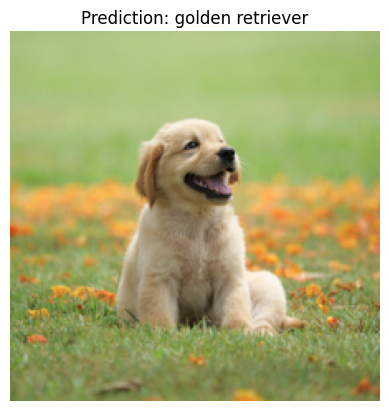

In [ ]:
# 1. Preprocess the image using the Hugging Face processor
inputs = processor(images=image, return_tensors="pt").to(device)
print(f"Input tensor shape: {inputs['pixel_values'].shape}")

# 2. Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# 3. Get predictions
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# 4. Get label name
labels = model.config.id2label
predicted_label = labels[predicted_class_idx]

print(f"\nPrediction: {predicted_label}")

# Display image
plt.imshow(image)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()

## 7. Conclusion

We have explored the paradigm shift from CNNs to Transformers in Vision.

**Key Takeaways:**
1.  **Patching:** We treat image patches ($16 \times 16$) as words in a sentence.
2.  **Global Context:** Unlike CNNs which look at local neighbors, the very first layer of a ViT allows the top-left pixel to attend to the bottom-right pixel.
3.  **Scale:** ViTs generally outperform CNNs when trained on massive datasets (ImageNet-21k, JFT-300M), but CNNs (like EfficientNet) are often better on smaller datasets due to their strong inductive bias.